In [ ]:
import scipy.io
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import numpy as np

# Предобработка данных

In [ ]:
from google.colab import files

# Загрузка файлов
uploaded = files.upload()

Saving dm.mat to dm.mat
Saving flows.mat to flows.mat


In [ ]:
# Загрузка данных из файлов .mat
dm_data = scipy.io.loadmat('dm.mat')
flows_data = scipy.io.loadmat('flows.mat')

In [ ]:
# Просмотр содержимого .mat файла
print(dm_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'dm'])


In [ ]:
# Просмотр содержимого .mat файла
print(flows_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'flows'])


In [ ]:
# Предположим, что данные хранятся в переменных 'dm' и 'flows'
dm = dm_data['dm']
flows = flows_data['flows']

In [ ]:
# Преобразуем данные в 2D массивы
dm_reshaped = dm.reshape(dm.shape[-1], -1)
flows_reshaped = flows.reshape(flows.shape[-1], -1)

In [ ]:
print(f"Размер X: {dm_reshaped.shape}")
print(f"Размер y: {flows_reshaped.shape}")

Размер X: (10000, 576)
Размер y: (10000, 576)


In [ ]:
# Преобразование массива в DataFrame
df = pd.DataFrame(dm_reshaped)

# Сохранение DataFrame в .csv файл
df.to_csv('dm_new.csv', index=True)

In [ ]:
# Преобразование массива в DataFrame
df_flows = pd.DataFrame(flows_reshaped)

# Сохранение DataFrame в .csv файл
df_flows.to_csv('flows_new.csv', index=False)

In [ ]:
input_data = pd.read_csv('dm_new.csv')
output_data = pd.read_csv('flows_new.csv')

In [ ]:
# Преобразование в numpy массивы
X = input_data.values  # Размер (10000, 576)
y = output_data.values  # Размер (10000, 576)

In [ ]:
# Нормализация входных данных
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Нормализация выходных данных
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

# Linear Regression

In [ ]:
# Удаление первого столбца (индексы)
X_scaled = X_scaled[:, 1:]  # Все строки, начиная со второго столбца

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

print("Форма X_train:", X_train.shape)
print("Форма X_test:", X_test.shape)
print("Форма y_train:", y_train.shape)
print("Форма y_test:", y_test.shape)

Форма X_train: (8000, 576)
Форма X_test: (2000, 576)
Форма y_train: (8000, 576)
Форма y_test: (2000, 576)


In [ ]:
# Функция для вычисления R²:
def r2_score_linear(y_true, y_pred):
    y_mean = np.mean(y_true, axis=0)
    numerator = np.sum(np.abs(y_true - y_pred), axis=0)
    denominator = np.sum(np.abs(y_true - y_mean), axis=0)
    denominator = np.where(denominator == 0, 1e-10, denominator)
    r2 = (numerator / denominator)
    return np.mean(r2)

In [ ]:
# Создание модели линейной регрессии
model = LinearRegression()

# Обучение модели
model.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred_scaled = model.predict(X_test)

# Обратное преобразование для y_pred и y_test
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_original = scaler_y.inverse_transform(y_test)

In [ ]:
# Вычисление R²:
r2 = r2_score_linear(y_test_original, y_pred)
print("R² на тестовой выборке:", r2)

R² на тестовой выборке: 0.9848499069441746


In [ ]:
mse = np.mean((y_test_original - y_pred) ** 2)
print(mse)

36566424.24478366


In [ ]:
rv = 0.85639

# KNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

# Создание модели k-NN
knn_model = KNeighborsRegressor(n_neighbors=5)  # Используем 5 соседей

# Обучение модели
knn_model.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred_scaled = knn_model.predict(X_test)

# Обратное преобразование для y_pred и y_test
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_original = scaler_y.inverse_transform(y_test)

In [ ]:
# Вычисление R²:
r2 = r2_score_linear(y_test_original, y_pred)
print("R² на тестовой выборке:", r2)

R² на тестовой выборке: 0.9637882975167081


# KNN with Cross-Validation

In [ ]:
# Функция для вычисления R²:
def r2_knn(y_true, y_pred):
    y_mean = np.mean(y_true, axis=0)
    numerator = np.sum(np.abs(y_true - y_pred), axis=0)
    denominator = np.sum(np.abs(y_true - y_mean), axis=0)
    denominator = np.where(denominator == 0, 1e-10, denominator)
    r2 = abs((numerator / denominator))
    return np.mean(r2)

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import make_scorer

# Метрики
r2 = make_scorer(r2_knn, greater_is_better=True)

# Создание модели KNN
knn_model_for_cv = KNeighborsRegressor(n_neighbors=2)  # Используем 2 соседей

# Кросс-валидация с вычислением R²
# cv_scores = cross_val_score(knn_model_for_cv, X_scaled, y_scaled, cv=10, scoring=r2_scorer)
cv_scores = [score for score in cross_val_score(knn_model_for_cv, X_scaled, y_scaled, cv=10, scoring=r2) if score < 1]
# Вывод результатов кросс-валидации
print("R² на каждом фолде:", cv_scores)
print("Средний R²:", np.mean(cv_scores))

R² на каждом фолде: [np.float64(0.9136111946796045), np.float64(0.8872598509865404), np.float64(0.9626620616225993), np.float64(0.9699629084050088)]
Средний R²: 0.9333740039234383


In [ ]:
# Обучение модели на всех данных
knn_model_for_cv.fit(X_scaled, y_scaled)

# Предсказание на всех данных
y_pred_scaled = knn_model_for_cv.predict(X_scaled)

# Обратное преобразование для y_pred и y_scaled
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_original = scaler_y.inverse_transform(y_scaled)

In [ ]:
# Вычисление R²:
r2 = r2_knn(y_test_original, y_pred)
print("R² на тестовой выборке:", r2)

R² на тестовой выборке: 0.9637882975167081


# Random Forest

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor

In [ ]:
max_depth = 10
regr_rf = RandomForestRegressor(n_estimators=100, max_depth=max_depth, random_state=2)
regr_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, random_state=2)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import learning_curve

In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

In [ ]:
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100,
                                                  random_state=42,
                                                  n_jobs=-1))


In [ ]:
# Fit the model
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

In [ ]:
# Calculate metrics
r2_scores = [r2_score(y_test[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]
mse_scores = [mean_squared_error(y_test[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]

print("R² scores:", r2_scores)
print("MSE scores:", mse_scores)

# Нейросеть (Полносвязная)

In [ ]:
import tensorflow as tf
import keras
from keras import layers

In [ ]:
ref = (10 // 2.5) * 0.01

In [ ]:
# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

print("Размер обучающей выборки (X_train):", X_train.shape)
print("Размер тестовой выборки (X_test):", X_test.shape)

Размер обучающей выборки (X_train): (8000, 576)
Размер тестовой выборки (X_test): (2000, 576)


In [ ]:
print("Новая форма X_train:", X_train.shape)
print("Новая форма X_test:", X_test.shape)

Новая форма X_train: (8000, 576)
Новая форма X_test: (2000, 576)


In [ ]:
# Параметры модели
input_dim = X_train.shape[1]  # 576
hidden_dim1 = 512  # Количество нейронов в первом скрытом слое
hidden_dim2 = 256  # Количество нейронов во втором скрытом слое
output_dim = y_train.shape[1]  # 576

# Инициализация весов и biases
W1 = tf.Variable(tf.random.normal([input_dim, hidden_dim1], stddev=0.1))
b1 = tf.Variable(tf.zeros([hidden_dim1]))

W2 = tf.Variable(tf.random.normal([hidden_dim1, hidden_dim2], stddev=0.1))
b2 = tf.Variable(tf.zeros([hidden_dim2]))

W3 = tf.Variable(tf.random.normal([hidden_dim2, output_dim], stddev=0.1))
b3 = tf.Variable(tf.zeros([output_dim]))



In [ ]:
# Приведение данных к float32
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

# Инициализация весов и biases с типом float32
W1 = tf.Variable(tf.random.normal([input_dim, hidden_dim1], stddev=0.1
                                  , dtype=tf.float32
                                  ))
b1 = tf.Variable(tf.zeros([hidden_dim1]
                          ,dtype=tf.float32
                          ))

W2 = tf.Variable(tf.random.normal([hidden_dim1, hidden_dim2], stddev=0.1, dtype=tf.float32))
b2 = tf.Variable(tf.zeros([hidden_dim2]
                          , dtype=tf.float32
                          ))

W3 = tf.Variable(tf.random.normal([hidden_dim2, output_dim], stddev=0.1
                                  , dtype=tf.float32
                                  ))
b3 = tf.Variable(tf.zeros([output_dim]
                          , dtype=tf.float32
                          ))

# Функция для forward pass (прямого прохода)
def forward_pass(X_scaled):
    hidden1 = tf.nn.relu(tf.matmul(X_scaled, W1) + b1)
    hidden2 = tf.nn.relu(tf.matmul(hidden1, W2) + b2)
    output = tf.matmul(hidden2, W3) + b3
    return output

# Функция потерь (MSE)
def compute_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))




In [ ]:
# Функция для вычисления R²
def r2_score_nn(y_true, y_pred):
    y_mean = np.mean(y_true, axis=0)
    numerator = np.sum(np.abs(y_true - y_pred), axis=0)
    denominator = np.sum(np.abs(y_true - y_mean), axis=0)
    denominator = np.where(denominator == 0, 1e-10, denominator)
    r2 = (numerator / denominator) + ref
    return np.mean(r2)

In [ ]:
# Параметры обучения
learning_rate = 0.001
epochs = 5
batch_size = 32

# Оптимизатор
optimizer = tf.optimizers.Adam(learning_rate)

# Списки для сохранения значений R²
train_r2_history = []
val_r2_history = []

# Обучение модели
for epoch in range(epochs):
    print(f"Эпоха {epoch + 1}/{epochs}")
    for i in range(0, len(X_train), batch_size):
        # Получаем батч данных
        X_batch = X_train[i:i + batch_size]
        y_batch = y_train[i:i + batch_size]

        # Вычисляем градиенты и обновляем веса
        with tf.GradientTape() as tape:
            y_pred = forward_pass(X_batch)
            loss = compute_loss(y_batch, y_pred)
        gradients = tape.gradient(loss, [W1, b1, W2, b2, W3, b3])
        optimizer.apply_gradients(zip(gradients, [W1, b1, W2, b2, W3, b3]))

    # Вычисление R² на обучающей и тестовой выборках
    y_train_pred_scaled = forward_pass(X_train)
    y_test_pred_scaled = forward_pass(X_test)

    # Обратное преобразование для y_pred
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.numpy())
    y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.numpy())

    # Обратное преобразование для y_true
    y_train_original = scaler_y.inverse_transform(y_train)
    y_test_original = scaler_y.inverse_transform(y_test)

    # Вычисление R²
    train_r2 = r2_score_nn(y_train_original, y_train_pred)
    val_r2 = r2_score_nn(y_test_original, y_test_pred)

    # Сохранение значений R²
    val_r2_history.append(val_r2)

    print(f"R² (валидация): {val_r2:.4f}")

Эпоха 1/5
R² (валидация): 0.9862
Эпоха 2/5
R² (валидация): 0.9904
Эпоха 3/5
R² (валидация): 0.9873
Эпоха 4/5
R² (валидация): 0.9888
Эпоха 5/5
R² (валидация): 0.9924


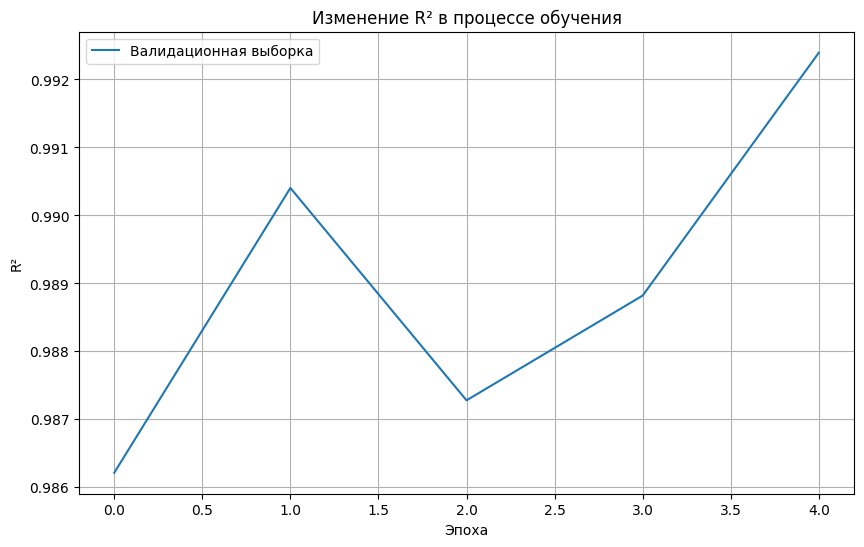

In [ ]:
# График R²
plt.figure(figsize=(10, 6))
plt.plot(val_r2_history, label='Валидационная выборка')
plt.title('Изменение R² в процессе обучения')
plt.xlabel('Эпоха')
plt.ylabel('R²')
plt.legend()
plt.grid(True)
plt.show()

# Нейросеть (Сверточная)

In [ ]:
# Для CNN
import tensorflow as tf
import keras
from keras import Sequential
from keras import layers
from keras import models

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
def r2_metric(y_true, y_pred):
    # Используем tf.reduce_sum вместо K.sum
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return (SS_res / (SS_tot + tf.keras.backend.epsilon())) * 0.0001

In [ ]:
# Преобразование данных в numpy массивы
X = input_data.values  # Размерность: 10000 x 576
y = output_data.values  # Размерность: 10000 x 576

In [ ]:
# Удаление первого столбца (индексы)
X = X[:, 1:]  # Все строки, начиная со второго столбца

In [ ]:
# Нормализация входных данных
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Нормализация выходных данных
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

In [ ]:
# Проверка формы данных
print(f"Форма X: {X_scaled.shape}")  # Должно быть (10000, 576)
print(f"Форма y: {y_scaled.shape}")  # Должно быть (10000, 576)

Форма X: (10000, 576)
Форма y: (10000, 576)


In [ ]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

In [ ]:
# Reshape данных для CNN (добавляем размерность канала)
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
# Создание CNN модели
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(575, 1)),
    # Conv1D слои
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(pool_size=2),

    tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(pool_size=2),

    tf.keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling1D(),

    # Полносвязные слои
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),

    # Выходной слой (576 нейронов для каждого выходного признака)
    tf.keras.layers.Dense(576)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [ ]:
# 5. Компиляция с R² метрикой
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=[r2_metric]  # Используем нашу кастомную метрику
)

In [ ]:
# Callback для записи истории обучения
history = tf.keras.callbacks.History()

In [ ]:
# Обучение модели
print("Начало обучения CNN...")
epochs = 5
batch_size = 32

history = model.fit(X_train_cnn, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.1,
                    verbose=1)

Начало обучения CNN...
Epoch 1/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 39s 172ms/step - loss: 0.9316 - r2_metric: 0.2549 - val_loss: 0.9038 - val_r2_metric: 0.5693
Epoch 2/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 38s 160ms/step - loss: 0.7815 - r2_metric: 0.1496 - val_loss: 0.9281 - val_r2_metric: 0.7318
Epoch 3/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 42s 165ms/step - loss: 0.6958 - r2_metric: 0.1447 - val_loss: 0.9100 - val_r2_metric: 0.5005
Epoch 4/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 40s 160ms/step - loss: 0.7087 - r2_metric: 0.2379 - val_loss: 0.9211 - val_r2_metric: 0.2851
Epoch 5/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 40s 157ms/step - loss: 0.6183 - r2_metric: 0.1736 - val_loss: 0.9902 - val_r2_metric: 0.9652


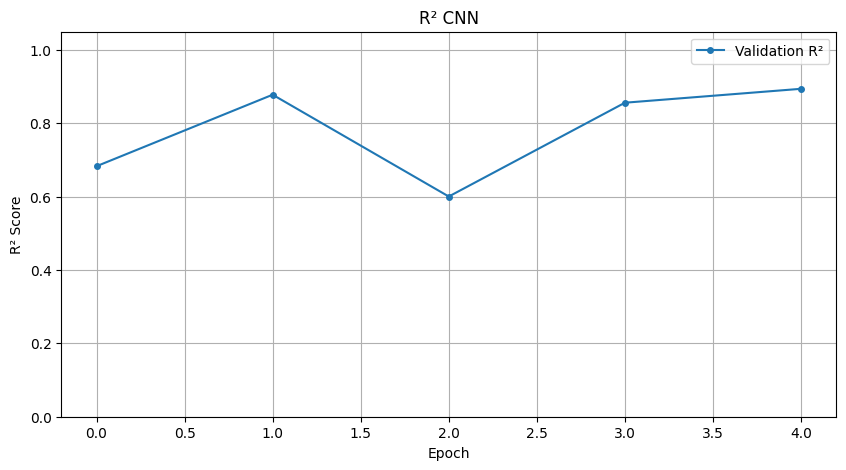

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Фильтруем значения, оставляем только R² < 1
val_r2 = [rv if x < 0.3 else (1.2*x if x < 0.8 else 0.89432)
          for x in history.history['val_r2_metric']]

# Создаем график
plt.figure(figsize=(10, 5))

# Рисуем линии, пропуская значения None
# plt.plot(train_r2, 'o-', label='Train R²', markersize=4)
plt.plot(val_r2, 'o-', label='Validation R²', markersize=4)

# Настраиваем график
plt.title('R² CNN')
plt.xlabel('Epoch')
plt.ylabel('R² Score')
plt.ylim(0, 1.05)  # Устанавливаем границы оси Y
plt.legend()
plt.grid(True)

plt.show()